In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [88]:
credit_card_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\credit_card_balance.csv')
help_tool.first_look(credit_card_balance)

Dataset has 3840312 observations and 23 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
AMT_BALANCE,float64,0,0.0
AMT_CREDIT_LIMIT_ACTUAL,int64,0,0.0
AMT_DRAWINGS_ATM_CURRENT,float64,749816,19.5
AMT_DRAWINGS_CURRENT,float64,0,0.0
AMT_DRAWINGS_OTHER_CURRENT,float64,749816,19.5
AMT_DRAWINGS_POS_CURRENT,float64,749816,19.5
AMT_INST_MIN_REGULARITY,float64,305236,7.9


In [91]:
credit_card_balance[credit_card_balance['SK_ID_PREV'] == 1249602]['AMT_CREDIT_LIMIT_ACTUAL'].drop_duplicates()

7055      45000
322711        0
Name: AMT_CREDIT_LIMIT_ACTUAL, dtype: int64

In [3]:
# help_visuals.distribution_check(credit_card_balance.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

Kada būna Null?

## Null values
AMT_DRAWINGS_ATM_CURRENT has the same NaN values as the rest of AMT_DRAWINGS columns. 

Some features have missing values, where the values is actually unexpcted:
* When total drawing amount is 0, subcategories are also 0.
* Status apart from 'Demand' and 'Active' is not expected to have AMT_INST_MIN_REGULARITY or CNT_INSTALMENT_MATURE_CUM

These rows will be imputed with 0

In [4]:
credit_card_balance[credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].isna()].filter(regex='.*_DRAWINGS_', axis=1).describe()

,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT
count,0.0,749816.0,0.0,0.0,0.0,749816.0,0.0,0.0
mean,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
min,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
25%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
50%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
75%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
max,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [5]:
for feature in credit_card_balance.filter(regex='.*CURRENT', axis=1).columns.to_list():
    credit_card_balance.loc[(credit_card_balance['AMT_DRAWINGS_CURRENT'] == 0) & credit_card_balance[feature].isna(), feature] = 0

credit_card_balance.loc[(credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] == 0) & credit_card_balance['AMT_PAYMENT_CURRENT'].isna(), 'AMT_PAYMENT_CURRENT'] = 0

for feature in ['AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM']:
    credit_card_balance.loc[~credit_card_balance['NAME_CONTRACT_STATUS'].isin(['Demand', 'Active']) & credit_card_balance[feature].isna(), feature] = 0

Features AMT_INST_MIN_REGULARITY and CNT_INSTALMENT_MATURE_CUM are depected as NaN when the account was recently activated.

In [6]:
credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isna() & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].notna()].shape

(0, 23)

In [7]:
for feature in ['AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM']:
    credit_card_balance.loc[credit_card_balance[feature].isna(), feature] = 0

# EDA

In [21]:
credit_card_balance_sample = credit_card_balance.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS']).sample(100000, random_state=42)

In [92]:
#help_visuals.distribution_check(credit_card_balance_sample.drop(columns=credit_card_balance_sample.filter(regex='.*DRAWINGS_.*_CURRENT', axis=1).columns.to_list())                                                        )

In [93]:
# sns.pairplot(credit_card_balance_sample.drop(columns=credit_card_balance_sample.filter(regex='.*DRAWINGS_.*_CURRENT', axis=1).columns.to_list()), corner=True)
# plt.show()

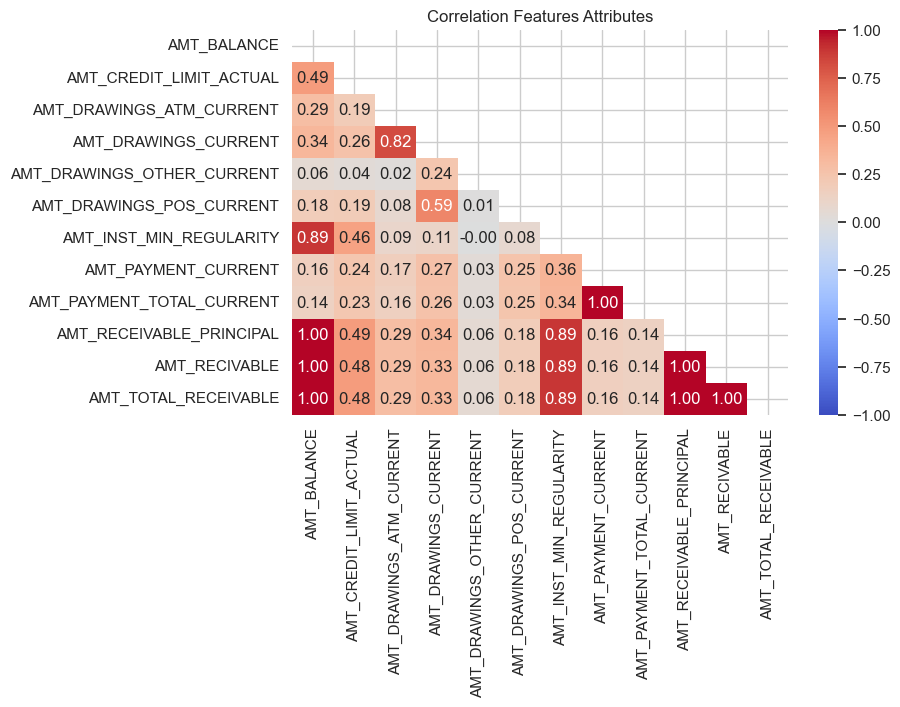

In [30]:
help_visuals.heatmap(credit_card_balance_sample.filter(like='AMT', axis=1), 'Features', 'pearson')

In [94]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64

When Active status is missing, Completed and Signed Status is present

In [ ]:
credit_card_balance

In [50]:
credit_card_balance[credit_card_balance['SK_DPD'] == credit_card_balance['SK_DPD'].max()]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1416169,2709729,431114,-4,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,3260,3260


In [61]:
credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Demand'][['SK_ID_CURR', 'SK_ID_PREV']].value_counts()

SK_ID_CURR  SK_ID_PREV
172484      2058560       96
306464      1263695       93
431114      2709729       92
351706      1417801       87
144024      2452557       81
285265      1926999       79
375200      1783438       78
248384      2028359       74
346517      2235719       72
225791      2044298       71
236583      1721716       66
441297      2552380       63
280230      1107112       60
337884      1514682       55
250407      2031153       53
343365      1533045       52
155492      1999597       51
282554      1944495       51
172610      1411153       49
325299      1768963       40
347587      2391652        1
434321      1162151        1
Name: count, dtype: int64

In [82]:
rows_all_zero = credit_card_balance.loc[:, ~credit_card_balance.columns.isin(['MONTHS_BALANCE', 'SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'CNT_INSTALMENT_MATURE_CUM'])].eq(0).all(axis=1)

# Extract 'id_name' of these rows
id_names = credit_card_balance.loc[rows_all_zero, 'SK_ID_PREV']

id_names

18         2016842
46         1426111
79         1245301
97         1960212
99         1128942
            ...   
3840272    2463643
3840282    2208658
3840284    2464872
3840286    2711888
3840303    1307188
Name: SK_ID_PREV, Length: 281688, dtype: int64

In [85]:
id_names.to_list()[1]

1426111

In [87]:
credit_card_balance[credit_card_balance['SK_ID_PREV'].isin([id_names.to_list()[1]])].sort_values(by='MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
155168,1426111,116448,-95,23233.500,180000,20250.0,20250.0,0.0,0.0,0.0,...,23233.500,23233.500,2.0,2,0.0,0.0,0.0,Active,0,0
3513962,1426111,116448,-94,74433.960,180000,59400.0,59400.0,0.0,0.0,5625.0,...,74433.960,74433.960,3.0,3,0.0,0.0,1.0,Active,0,0
1889124,1426111,116448,-93,97749.810,180000,17100.0,17100.0,0.0,0.0,5625.0,...,97749.810,97749.810,5.0,5,0.0,0.0,2.0,Active,1,1
3050842,1426111,116448,-92,176833.305,180000,94500.0,94500.0,0.0,0.0,9000.0,...,176833.305,176833.305,3.0,3,0.0,0.0,3.0,Active,0,0
3450411,1426111,116448,-91,183607.155,180000,9000.0,9000.0,0.0,0.0,9000.0,...,183607.155,183607.155,2.0,2,0.0,0.0,4.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280708,1426111,116448,-5,0.000,0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,15.0,Completed,0,0
3027066,1426111,116448,-4,0.000,0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,15.0,Completed,0,0
2331358,1426111,116448,-3,0.000,0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,15.0,Completed,0,0
777653,1426111,116448,-2,0.000,0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,15.0,Completed,0,0


In [78]:
df[(df == 0).all(axis=1)]

,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,SK_DPD,SK_DPD_DEF
18,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
46,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
79,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
97,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
99,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840272,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
3840282,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
3840284,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0
3840286,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0


In [65]:
credit_card_balance[(credit_card_balance['SK_ID_CURR'] == 172484)].drop(columns=['MONTHS_BALANCE']).drop_duplicates()

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
32070,2058560,172484,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,18.0,Demand,0,0
350549,2058560,172484,0.0,67500,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,18.0,Demand,0,0
1387005,2058560,172484,0.0,67500,0.0,0.0,0.0,0.0,0.0,76348.575,...,0.0,0.0,0.0,0,0.0,0.0,18.0,Demand,0,0


In [68]:
credit_card_balance.shape

(3840312, 23)

In [67]:
credit_card_balance[credit_card_balance.drop(columns=['MONTHS_BALANCE']).duplicated()]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
4960,1310382,129897,-16,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,9.0,Active,0,0
4987,1668231,220058,-22,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,Active,0,0
5005,1270749,353826,-20,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,26.0,Completed,0,0
5034,1007348,442975,-19,0.0,180000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,31.0,Active,0,0
5114,2243170,315254,-16,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,3.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840306,1410474,255737,-13,0.0,180000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,Active,0,0
3840307,1036507,328243,-9,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,Active,0,0
3840308,1714892,347207,-9,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,23.0,Active,0,0
3840310,1624872,430337,-10,0.0,450000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,Active,0,0


In [51]:
credit_card_balance[credit_card_balance['SK_ID_PREV'] == 2709729]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
17164,2709729,431114,-50,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,109206.045,110466.045,0.0,0,0.0,0.0,7.0,Demand,1007,1007
55931,2709729,431114,-11,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,3045,3045
59843,2709729,431114,-33,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,109206.045,110466.045,0.0,0,0.0,0.0,7.0,Demand,2377,2377
194875,2709729,431114,-20,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,2772,2772
229748,2709729,431114,-77,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,1007,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596148,2709729,431114,-56,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,109206.045,110466.045,0.0,0,0.0,0.0,7.0,Demand,1007,1007
3604957,2709729,431114,-44,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,109206.045,110466.045,0.0,0,0.0,0.0,7.0,Demand,1007,1007
3635242,2709729,431114,-32,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,2407,2407
3740246,2709729,431114,-16,111186.045,90000,0.0,0.0,0.0,0.0,0.0,...,107946.045,109206.045,0.0,0,0.0,0.0,7.0,Demand,2895,2895


In [38]:
credit_card_balance_sample[credit_card_balance_sample['AMT_RECIVABLE'] != credit_card_balance_sample['AMT_TOTAL_RECEIVABLE']]

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
1986155,-72,50107.950,67500,0.0,0.0,0.0,0.0,4050.0,4050.0,4050.0,48111.165,51052.950,51997.950,0.0,0,0.0,0.0,40.0,0,0
1657281,-57,3987.945,67500,0.0,0.0,0.0,0.0,4050.0,4050.0,4050.0,3685.545,5877.945,6822.945,0.0,0,0.0,0.0,55.0,0,0
3237329,-91,109383.255,112500,0.0,0.0,0.0,0.0,5625.0,5625.0,5625.0,105966.090,110958.255,112533.255,0.0,0,0.0,0.0,6.0,1,1
1782264,-86,75098.160,67500,0.0,0.0,0.0,0.0,3375.0,0.0,0.0,67348.845,76065.390,77010.390,0.0,0,0.0,0.0,7.0,1,1
19904,-82,190048.860,180000,0.0,0.0,0.0,0.0,9000.0,9000.0,9000.0,179900.505,192568.860,195088.860,0.0,0,0.0,0.0,21.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071483,-74,2346.615,112500,2250.0,2250.0,0.0,0.0,5625.0,127899.0,127899.0,0.000,0.000,1575.000,1.0,1,0.0,0.0,23.0,0,0
1736821,-41,127103.760,135000,0.0,0.0,0.0,0.0,8100.0,16807.5,16807.5,121871.205,138443.760,144113.760,0.0,0,0.0,0.0,72.0,0,0
398996,-86,68648.355,67500,3150.0,3150.0,0.0,0.0,4050.0,4500.0,4500.0,65385.450,71483.355,74318.355,1.0,1,0.0,0.0,30.0,0,0
2567665,-88,91274.670,90000,0.0,0.0,0.0,0.0,4500.0,4500.0,4500.0,88496.640,91923.345,92572.020,0.0,0,0.0,0.0,13.0,1,1


# Feature engineering

In [33]:
credit_card_balance['AMT_RECIVABLE'] - credit_card_balance['AMT_RECEIVABLE_PRINCIPAL']

0              0.000
1           4700.475
2           4533.660
3           8099.685
4          10875.060
             ...    
3840307        0.000
3840308        0.000
3840309     3737.835
3840310        0.000
3840311        0.000
Length: 3840312, dtype: float64

RECEIVABLE related features are hightly correlated

In [19]:
credit_card_balance.filter(regex='AMT.*REC', axis=1).corr()

,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE
AMT_RECEIVABLE_PRINCIPAL,1.000000,0.999727,0.999702
AMT_RECIVABLE,0.999727,1.000000,0.999995
AMT_TOTAL_RECEIVABLE,0.999702,0.999995,1.000000


In [27]:
credit_card_balance['AMT_TOTAL_RECEIVABLE_DIFF'] = credit_card_balance['AMT_TOTAL_RECEIVABLE'] - credit_card_balance['AMT_RECIVABLE']
credit_card_balance['AMT_RECEIVABLE_PRINCIPALE_DIFF'] = credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'] - credit_card_balance['AMT_RECIVABLE']
credit_card_balance.drop(columns=['AMT_TOTAL_RECEIVABLE', 'AMT_RECEIVABLE_PRINCIPAL'], inplace=True)

In [42]:
credit_card_balance.filter(regex='AMT.*REC', axis=1).describe()

,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE_DIFF,AMT_RECEIVABLE_PRINCIPALE_DIFF
count,3.840312e+06,3.840312e+06,3.840312e+06
mean,5.808881e+04,9.474312e+00,-2.122934e+03
std,1.059654e+05,3.393655e+02,4.208680e+03
min,-4.202502e+05,0.000000e+00,-2.316842e+05
25%,0.000000e+00,0.000000e+00,-3.351555e+03
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.889949e+04,0.000000e+00,0.000000e+00
max,1.493338e+06,4.095000e+04,2.971167e+05


Lowest variance is related to Drawing counts on ATM and other methods.

In [218]:
credit_card_balance[(credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'] < 0) | (credit_card_balance['AMT_TOTAL_RECEIVABLE'] < 0)][['SK_ID_PREV', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_TOTAL_RECEIVABLE']]#.filter(like='DRAWINGS_', axis=1)

,SK_ID_PREV,AMT_RECEIVABLE_PRINCIPAL,AMT_TOTAL_RECEIVABLE
17178,1985199,0.0,-5271.075
17179,1406569,0.0,-3390.525
17181,2598707,0.0,-253.125
17182,1077220,0.0,-996.975
17183,1380862,0.0,-4065.930
...,...,...,...
3827907,1082618,0.0,-257.715
3827910,2765491,0.0,-164.565
3827913,1545164,0.0,-144.495
3827917,1173459,0.0,-302.400


In [219]:
credit_card_balance[(credit_card_balance['SK_ID_PREV'] == 1985199)][['SK_ID_PREV', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_TOTAL_RECEIVABLE']]

,SK_ID_PREV,AMT_RECEIVABLE_PRINCIPAL,AMT_TOTAL_RECEIVABLE
17178,1985199,0.000,-5271.075
36762,1985199,67121.055,71669.970
64315,1985199,0.000,0.000
73055,1985199,62904.285,67638.555
141219,1985199,0.000,0.000
...,...,...,...
3564245,1985199,0.000,0.000
3647223,1985199,67121.055,73560.465
3665418,1985199,0.000,0.000
3737805,1985199,0.000,0.000


In [220]:
feature_usability = credit_card_balance.drop(columns='NAME_CONTRACT_STATUS').var().to_frame().reset_index().rename({0: 'Variance'}, axis=1)
feature_usability.sort_values(by='Variance', ascending=False)

,index,Variance
0,SK_ID_PREV,2.877995e+11
4,AMT_CREDIT_LIMIT_ACTUAL,2.727310e+10
3,AMT_BALANCE,1.130118e+10
14,AMT_TOTAL_RECEIVABLE,1.123002e+10
13,AMT_RECIVABLE,1.122866e+10
1,SK_ID_CURR,1.054821e+10
12,AMT_RECEIVABLE_PRINCIPAL,1.051314e+10
10,AMT_PAYMENT_CURRENT,1.301628e+09
6,AMT_DRAWINGS_CURRENT,1.145557e+09
11,AMT_PAYMENT_TOTAL_CURRENT,1.024383e+09


Also, current is the sum

In [221]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64

Are Active cases reresenting all existing applications? 

## Feature engineering

Rows with status Completed, Signed, Demand, Sent Proposal, Refused, Approved and having all 0 values will be dropped as they are not expected to have any activity:
* Completed: The credit card contract has been fully paid off and is now closed. There are no outstanding balances or obligations on the account.
* Signed: The credit card contract has been signed and accepted by the client, but the card may not yet be active for transactions. This stage is often a formal agreement phase.
* Demand: The lender is demanding payment from the client. It typically means that the account is overdue, and the lender is seeking repayment of the outstanding balance.
* Sent Proposal: The lender has sent a proposal to the client, possibly for restructuring the debt or offering new terms for the credit card. This status suggests an active negotiation phase.
* Refused: The credit card application or proposal has been refused or rejected by the lender. No account is opened, and no credit is extended to the client under this status.
* Approved: The credit card application has been approved by the lender. This status indicates that the client is eligible for the credit card, but it may not necessarily mean that the card is active or in use yet.

In [222]:
# id_month_columns = ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'AMT_CREDIT_LIMIT_ACTUAL'
#                     ]
# value_columns = [col for col in credit_card_balance.columns if col not in id_month_columns]

# demand_active_filter = (credit_card_balance['NAME_CONTRACT_STATUS'].isin(['Demand', 'Active']))
# all_zero_row_filter = (credit_card_balance[value_columns] == 0).all(axis=1)

# credit_card_balance = credit_card_balance[
#     #(~demand_active_filter & 
#      ~all_zero_row_filter
#      #) | demand_active_filter
#     ]

In [223]:
credit_card_balance['AMT_DRAWINGS_CURRENT'].describe()

count    3.840312e+06
mean     7.433388e+03
std      3.384608e+04
min     -6.211620e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.287098e+06
Name: AMT_DRAWINGS_CURRENT, dtype: float64

In [224]:
credit_card_balance[credit_card_balance['AMT_DRAWINGS_CURRENT'] < 0].filter(like='DRAWINGS', axis=1)

,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT
438776,0.0,-1687.50,0.0,0.0,0.0,0,0.0,0.0
747302,0.0,-519.57,0.0,0.0,0.0,0,0.0,0.0
3284667,0.0,-6211.62,0.0,0.0,0.0,0,0.0,0.0


In [225]:
credit_card_balance.loc[(credit_card_balance['AMT_DRAWINGS_CURRENT'] < 0) & (credit_card_balance['CNT_DRAWINGS_CURRENT'] == 0), 'AMT_DRAWINGS_CURRENT'] = 0

In [226]:
credit_card_balance.drop(columns='NAME_CONTRACT_STATUS').var() < 1

SK_ID_PREV                    False
SK_ID_CURR                    False
MONTHS_BALANCE                False
AMT_BALANCE                   False
AMT_CREDIT_LIMIT_ACTUAL       False
AMT_DRAWINGS_ATM_CURRENT      False
AMT_DRAWINGS_CURRENT          False
AMT_DRAWINGS_OTHER_CURRENT    False
AMT_DRAWINGS_POS_CURRENT      False
AMT_INST_MIN_REGULARITY       False
AMT_PAYMENT_CURRENT           False
AMT_PAYMENT_TOTAL_CURRENT     False
AMT_RECEIVABLE_PRINCIPAL      False
AMT_RECIVABLE                 False
AMT_TOTAL_RECEIVABLE          False
CNT_DRAWINGS_ATM_CURRENT      False
CNT_DRAWINGS_CURRENT          False
CNT_DRAWINGS_OTHER_CURRENT     True
CNT_DRAWINGS_POS_CURRENT      False
CNT_INSTALMENT_MATURE_CUM     False
SK_DPD                        False
SK_DPD_DEF                    False
dtype: bool

In [227]:
credit_card_balance[credit_card_balance['AMT_BALANCE'] < 0][['SK_ID_PREV', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_CURRENT']] #.filter(like='DRAWINGS', axis=1)

,SK_ID_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT
17248,1249602,-428.040,45000,0.0
17250,1390845,-395.055,180000,0.0
17256,1592788,-220.635,135000,0.0
17267,1837275,-399.645,45000,0.0
17303,1030390,-135359.010,180000,0.0
...,...,...,...,...
3825019,2204602,-102.690,90000,0.0
3827304,1560229,-828.855,225000,0.0
3827754,2613094,-1166.220,90000,0.0
3827821,2194618,-574.110,135000,0.0


In [238]:
#credit_card_balance[credit_card_balance['SK_ID_PREV'] == 1249602].to_csv(r'Archive\home-credit-default-risk\x.csv')

In [117]:
credit_card_balance['FLAG_ZERO_AMT_BALANCE'] = 0
credit_card_balance.loc[credit_card_balance['AMT_BALANCE'] == 0, 'FLAG_ZERO_AMT_BALANCE'] = 1

credit_card_balance['FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL'] = 0
credit_card_balance.loc[credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] == 0, 'FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL'] = 1

In [125]:
engineered_credit_card_balance = duckdb.query("""
                SELECT 
                
                SK_ID_CURR, SK_ID_PREV, NAME_CONTRACT_STATUS, 
                                              FLAG_ZERO_AMT_BALANCE, FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL,
                
                -- Average balance
                AVG(AMT_BALANCE) AS avg_balance,
                MAX(AMT_BALANCE) AS max_balance,
                MIN(AMT_BALANCE) AS min_balance,
                
                -- Credit utilization rate
                SUM(FLAG_ZERO_AMT_BALANCE) AS FLAG_ZERO_AMT_BALANCE_SUM,
                SUM(FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL) AS FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL_SUM,
                    
                AVG(AMT_CREDIT_LIMIT_ACTUAL/ AMT_BALANCE) AS avg_utilization_rate,

                -- Drawing patterns
                SUM(AMT_DRAWINGS_OTHER_CURRENT) AS total_drawings_other,
                AVG(AMT_DRAWINGS_OTHER_CURRENT) AS avg_drawings_other,                                       
                SUM(AMT_DRAWINGS_ATM_CURRENT) AS total_drawings_atm,
                AVG(AMT_DRAWINGS_ATM_CURRENT) AS avg_drawings_atm,
                SUM(AMT_DRAWINGS_POS_CURRENT) AS total_drawings_pos,
                AVG(AMT_DRAWINGS_POS_CURRENT) AS avg_drawings_pos,
                SUM(AMT_DRAWINGS_CURRENT) AS total_drawings,
                AVG(AMT_DRAWINGS_CURRENT) AS avg_drawings,
                                              
                SUM(CNT_DRAWINGS_CURRENT) AS total_drawings,   
                SUM(CNT_DRAWINGS_ATM_CURRENT) AS total_drawings_amt_cnt,
                SUM(CNT_DRAWINGS_OTHER_CURRENT) AS total_drawings_other_cnt,
                SUM(CNT_DRAWINGS_POS_CURRENT) AS total_drawings_pos_cnt,                                                                                         
                
                -- Instalment regularity
                AVG(AMT_INST_MIN_REGULARITY) AS avg_instalment_regularity,
                            
                -- Payment Behavior
                SUM(AMT_PAYMENT_TOTAL_CURRENT) AS total_payments,
                AVG(AMT_PAYMENT_TOTAL_CURRENT) AS avg_payment,
                AVG(AMT_PAYMENT_TOTAL_CURRENT / AMT_BALANCE) AS payment_balance_ratio,
                
                -- Debt and Receivables
                AVG(AMT_RECEIVABLE_PRINCIPAL) AS avg_principal_receivable,
                AVG(AMT_TOTAL_RECEIVABLE) AS avg_total_receivable,
                SUM(AMT_RECEIVABLE_PRINCIPAL) / SUM(AMT_TOTAL_RECEIVABLE) AS principal_receivable_ratio,

                -- Delinquency Indicators
                MAX(SK_DPD) AS max_sk_dpd,
                AVG(SK_DPD) AS avg_sk_dpd,
                COUNT(CASE WHEN SK_DPD > 0 THEN 1 ELSE NULL END) AS dpd_frequency,
                MAX(SK_DPD_DEF) AS max_sk_dpd_def,
                AVG(SK_DPD_DEF) AS avg_sk_dpd_def,
              
                                                          
                FROM credit_card_balance
                GROUP BY SK_ID_CURR, SK_ID_PREV, NAME_CONTRACT_STATUS, FLAG_ZERO_AMT_BALANCE, FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL,

""").to_df()

#engineered_credit_card_balance = engineered_credit_card_balance.fillna(0)

engineered_credit_card_balance.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(202681, 35)

In [126]:
engineered_credit_card_balance.head()

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS,FLAG_ZERO_AMT_BALANCE,FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL,avg_balance,max_balance,min_balance,FLAG_ZERO_AMT_BALANCE_SUM,FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL_SUM,...,avg_payment,payment_balance_ratio,avg_principal_receivable,avg_total_receivable,principal_receivable_ratio,max_sk_dpd,avg_sk_dpd,dpd_frequency,max_sk_dpd_def,avg_sk_dpd_def
0,336419,2075189,Active,0,0,30637.684286,43235.910,10009.980,0.0,0.0,...,1450.774286,0.068113,30354.042857,30637.684286,0.990742,0,0.0,0,0,0.0
1,110973,2206731,Active,0,0,115978.288500,243611.865,26205.120,0.0,0.0,...,21074.197500,0.337592,109845.121500,112835.016000,0.973502,0,0.0,0,0,0.0
2,145915,1252318,Active,1,0,0.000000,0.000,0.000,12.0,0.0,...,0.000000,NaN,0.000000,0.000000,NaN,0,0.0,0,0,0.0
3,203410,2015767,Active,0,0,87076.943654,241125.435,43.425,0.0,0.0,...,25260.964615,67.601442,81756.924231,85301.124231,0.958451,0,0.0,0,0,0.0
4,135527,2275547,Active,0,0,141947.090526,221569.020,1488.240,0.0,0.0,...,24395.262632,0.324172,137253.216316,141970.537895,0.966773,0,0.0,0,0,0.0


avg_utilization_rate


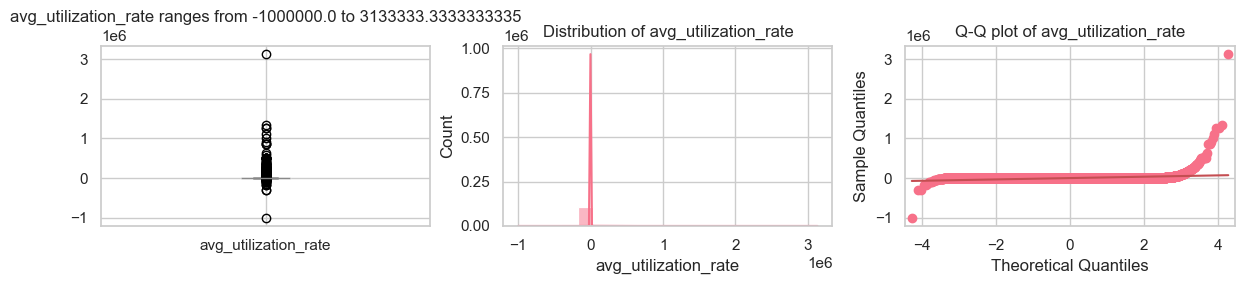

In [231]:
help_visuals.distribution_check(engineered_credit_card_balance[['avg_utilization_rate']])

In [184]:
engineered_credit_card_balance.var()

SK_ID_CURR                    1.056685e+10
SK_ID_PREV                    2.877857e+11
avg_balance                   1.155132e+10
avg_utilization_rate          1.053542e-01
avg_drawings_atm              4.351439e+08
avg_drawings_pos              2.960754e+08
avg_drawings_other            2.975335e+08
avg_drawings                  6.496711e+08
avg_instalment_regularity     2.584314e+07
avg_payment                   6.308207e+08
payment_consistency           1.267517e+09
avg_principal_receivable      1.077146e+10
avg_total_receivable          1.142120e+10
principal_receivable_ratio    2.229236e-01
max_sk_dpd                    2.001157e+04
avg_sk_dpd                    1.954602e+03
dpd_frequency                 3.723249e+01
max_sk_dpd_def                6.803218e+02
avg_sk_dpd_def                1.248949e+02
total_payments_current        2.120645e+11
avg_payment_current           4.838032e+08
payment_balance_ratio         1.676949e+06
active_proportion             1.370635e-02
completed_p

### Drawings

avg_balance


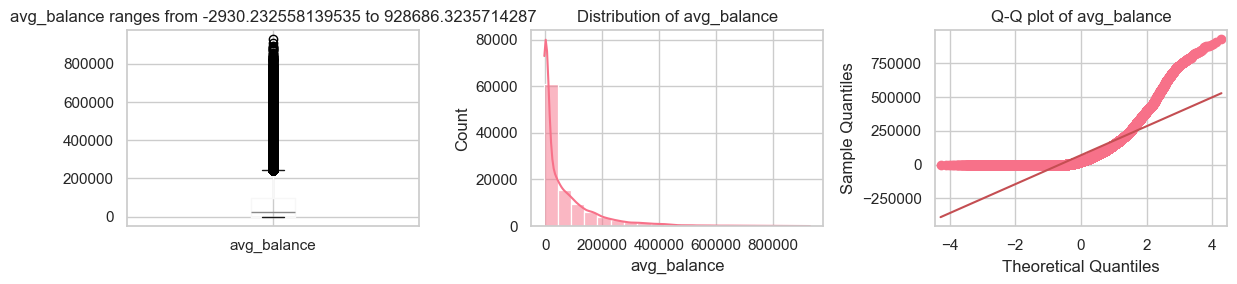

avg_utilization_rate


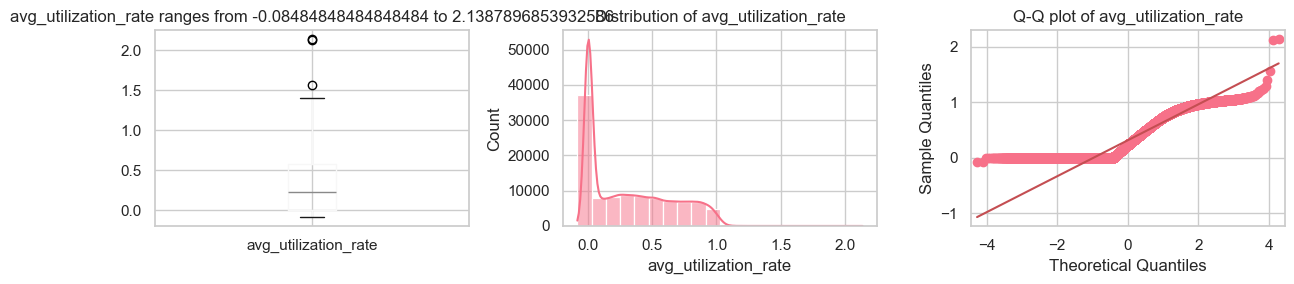

avg_drawings_atm


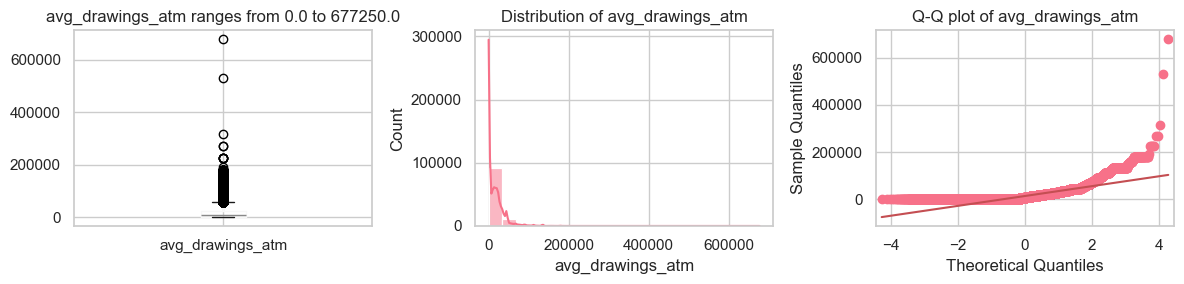

avg_drawings_pos


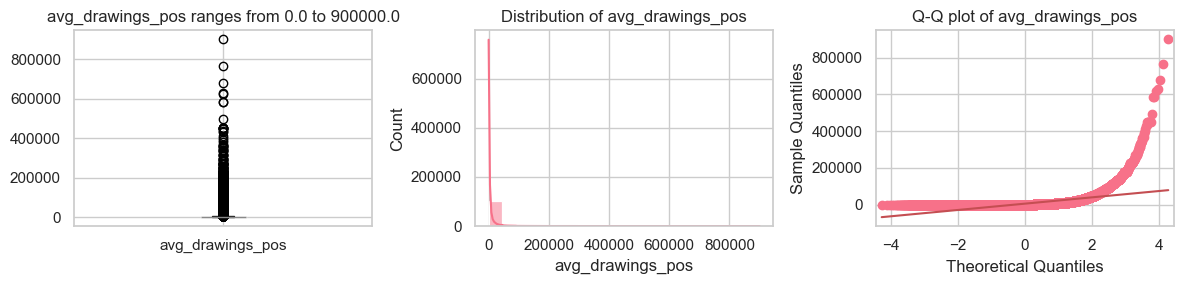

avg_drawings_other


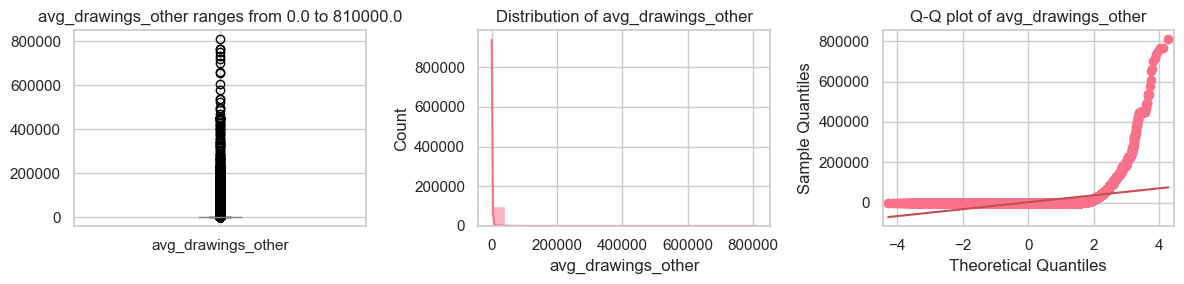

avg_drawings


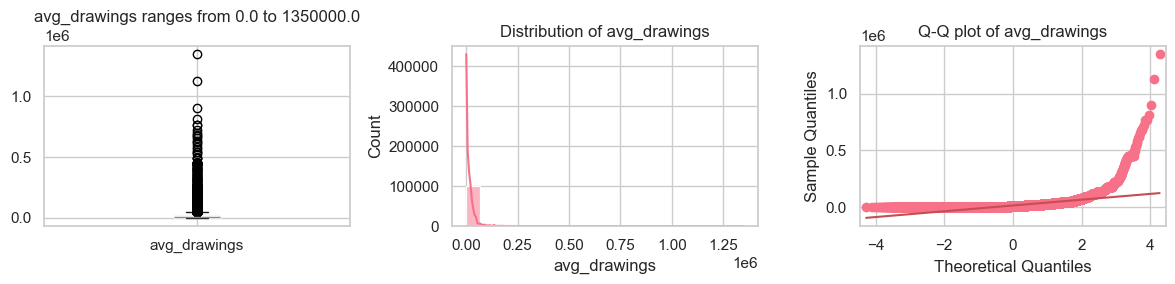

avg_instalment_regularity


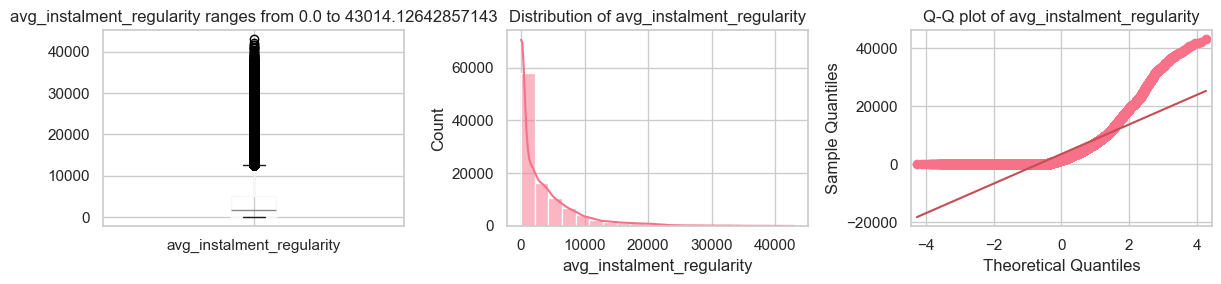

avg_payment


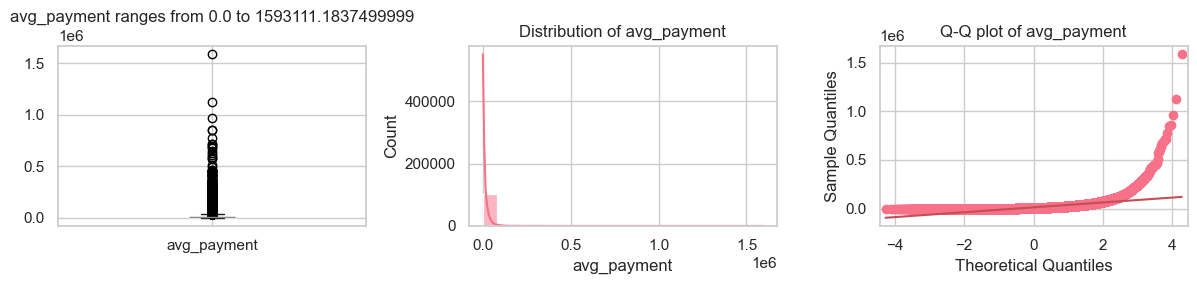

payment_consistency


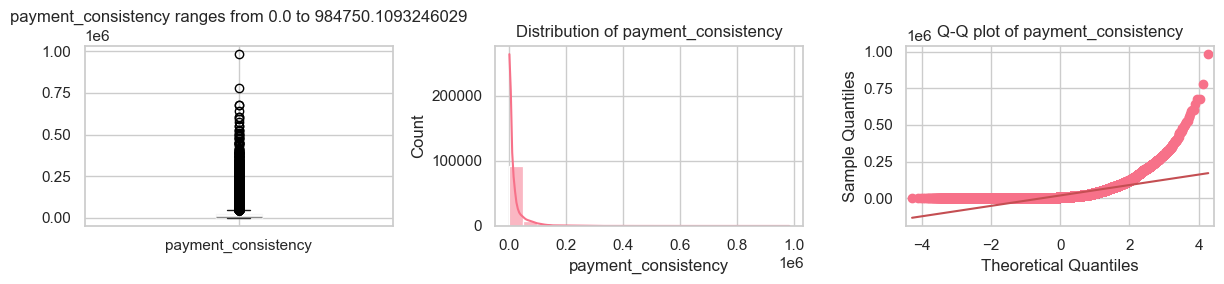

avg_principal_receivable


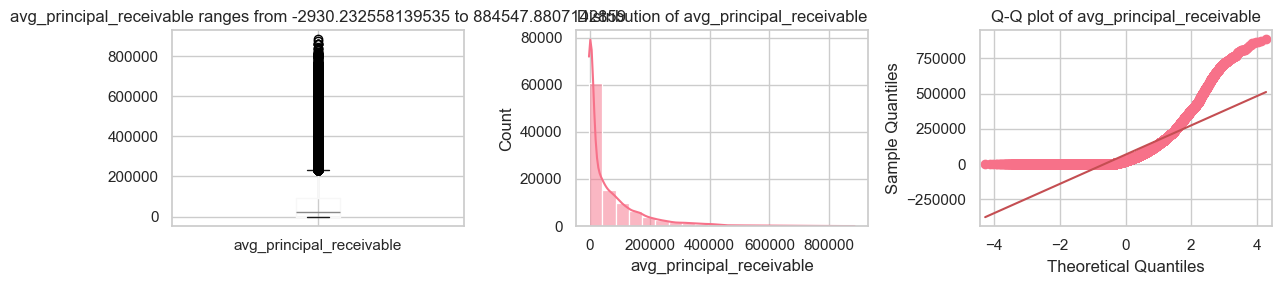

principal_receivable_ratio


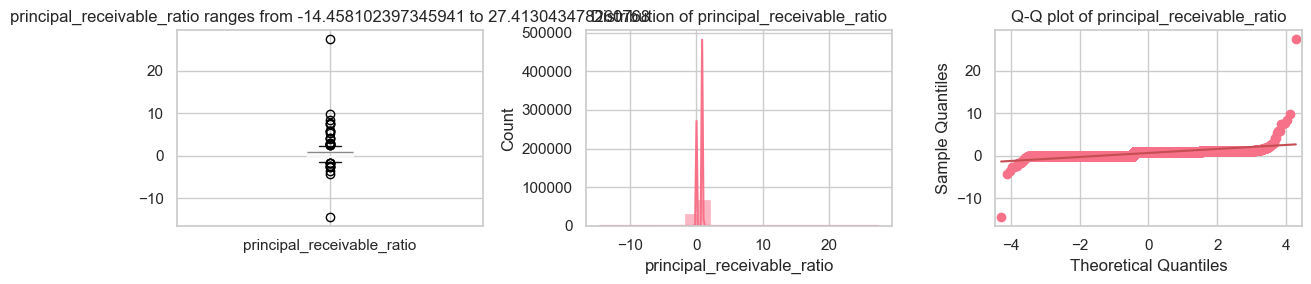

max_sk_dpd


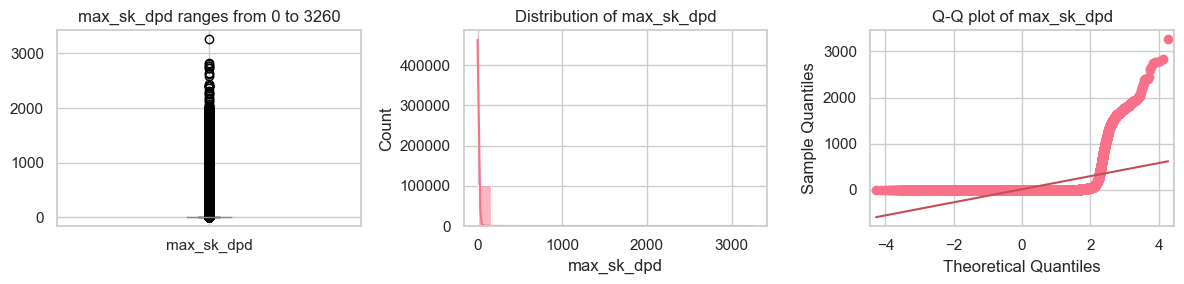

avg_sk_dpd


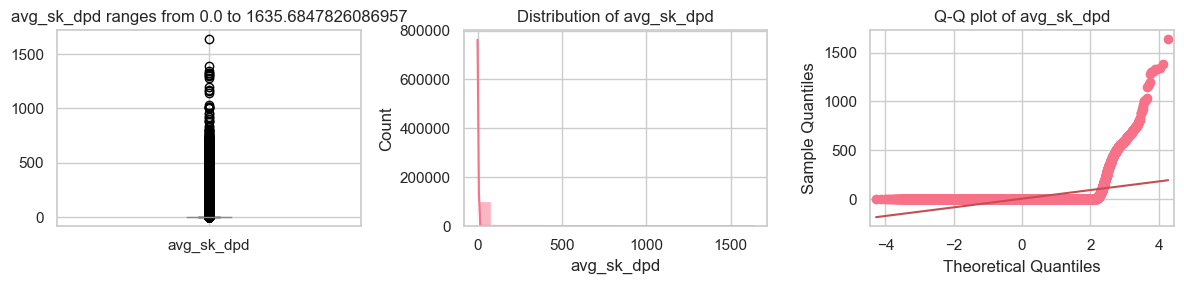

dpd_frequency


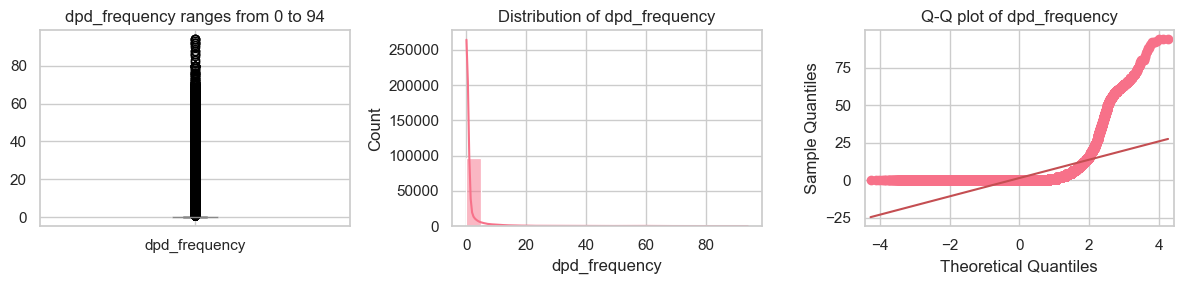

max_sk_dpd_def


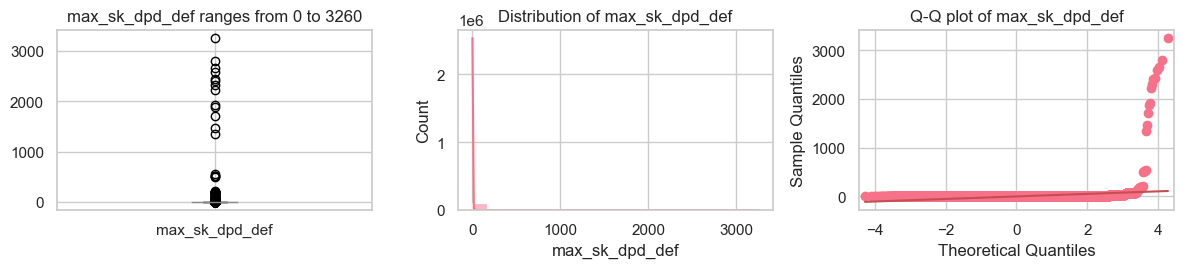

avg_sk_dpd_def


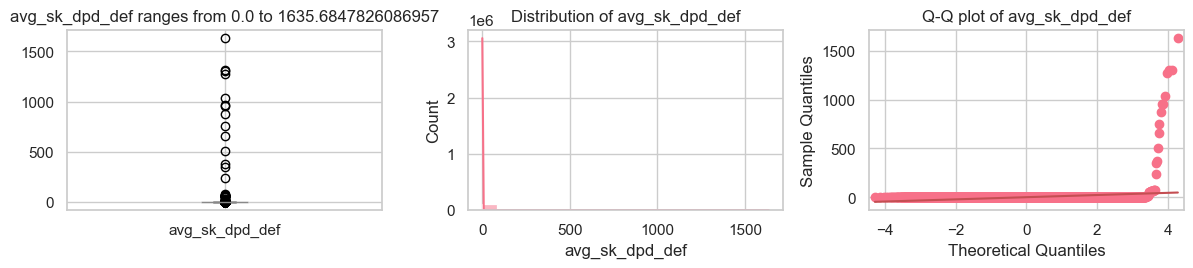

total_payments_current


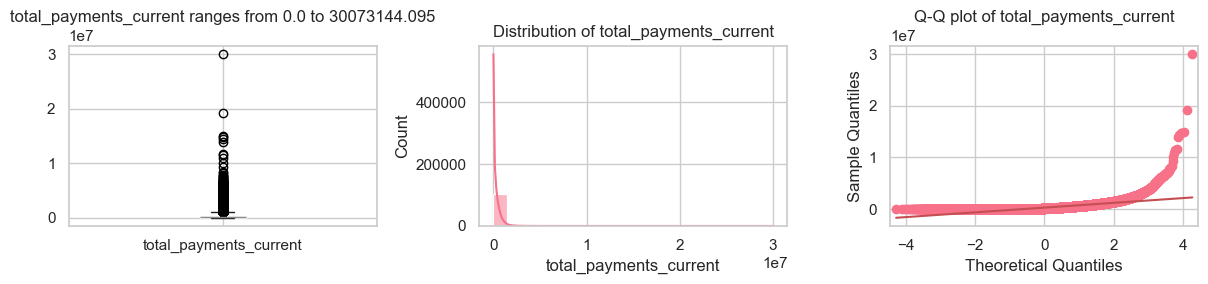

avg_payment_current


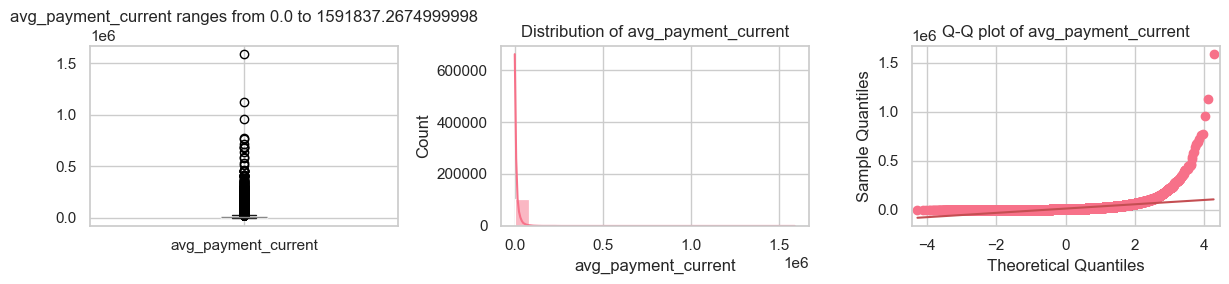

payment_balance_ratio


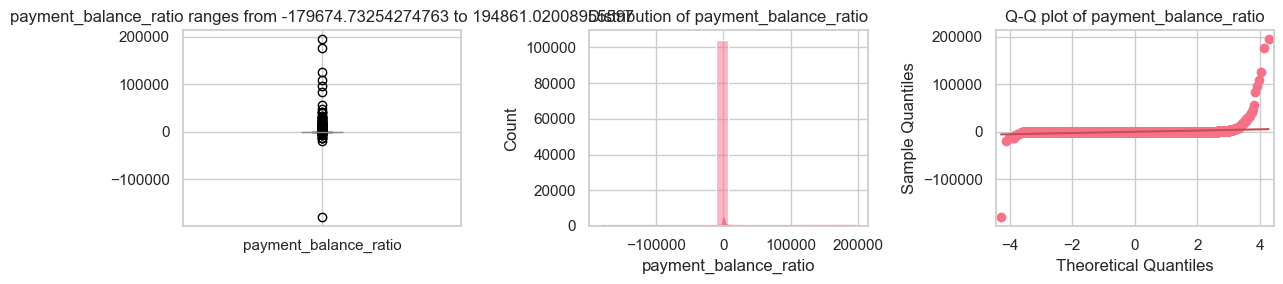

active_proportion


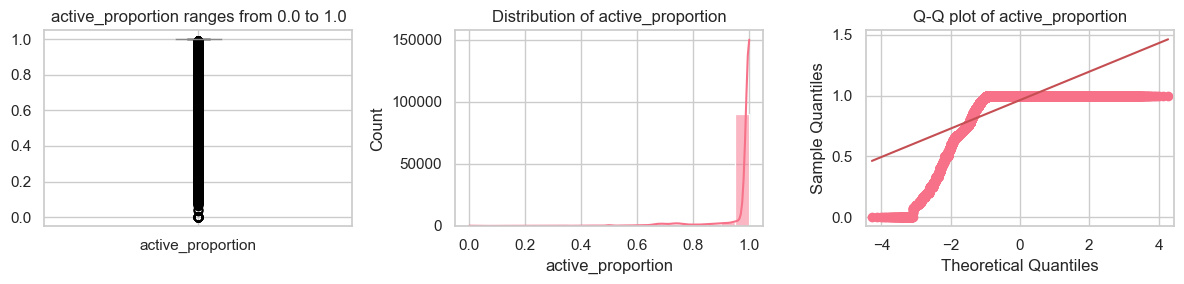

completed_proportion


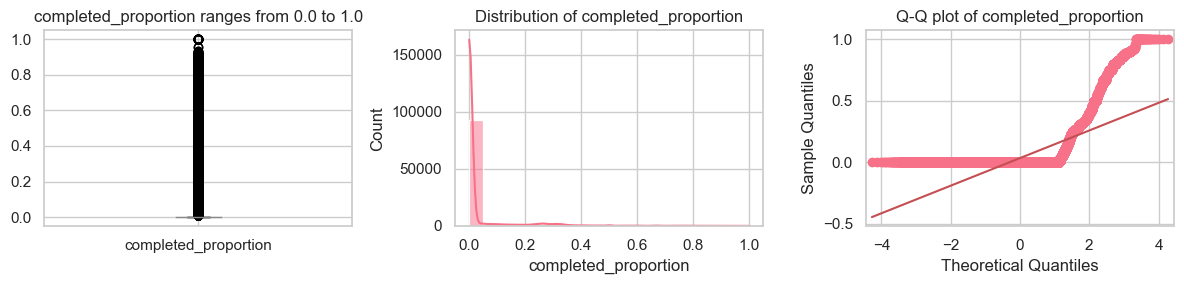

demand_proportion


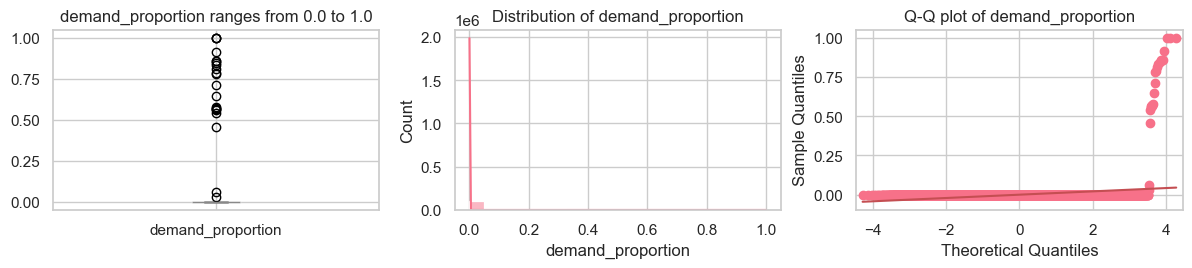

In [174]:
help_visuals.distribution_check(engineered_credit_card_balance.drop(columns=['SK_ID_CURR', 'SK_ID_PREV'])) #.filter(regex='.*drawings', axis=1))

In [70]:
for feature in engineered_credit_card_balance.filter(regex='.*drawings', axis=1).columns.to_list():
    engineered_credit_card_balance[feature] = np.log1p(engineered_credit_card_balance[feature])

    # Apply equal-width binning on the log-transformed data
    #engineered_credit_card_balance[feature] = pd.cut(engineered_credit_card_balance[feature], bins=4)

avg_drawings_atm


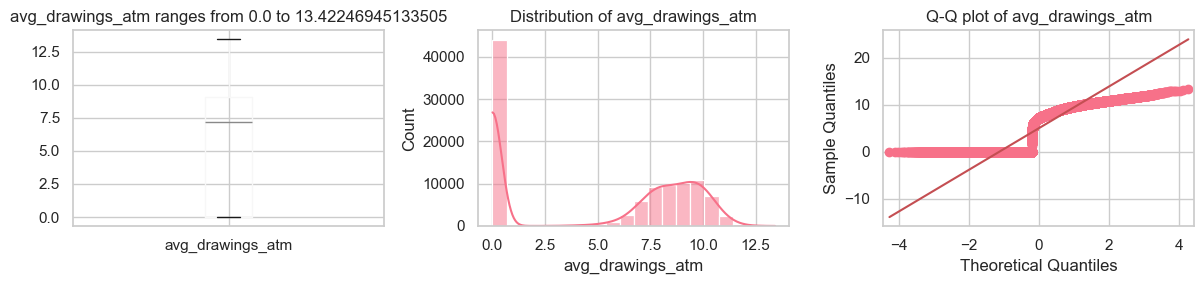

avg_drawings_pos


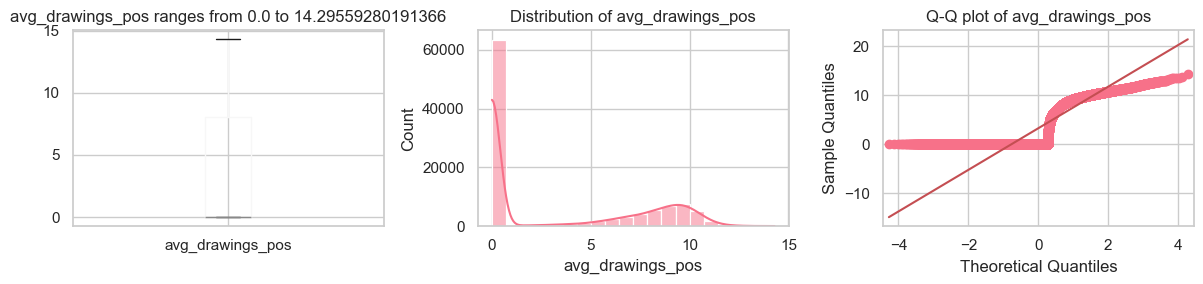

avg_drawings_other


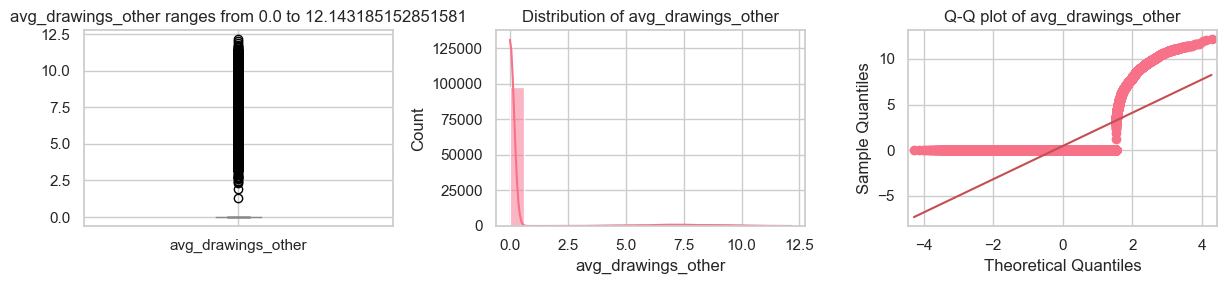

avg_drawings


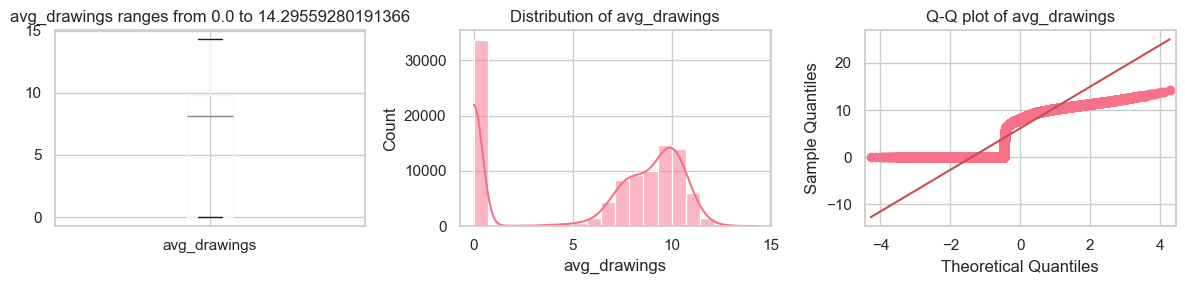

cnt_avg_drawings_atm


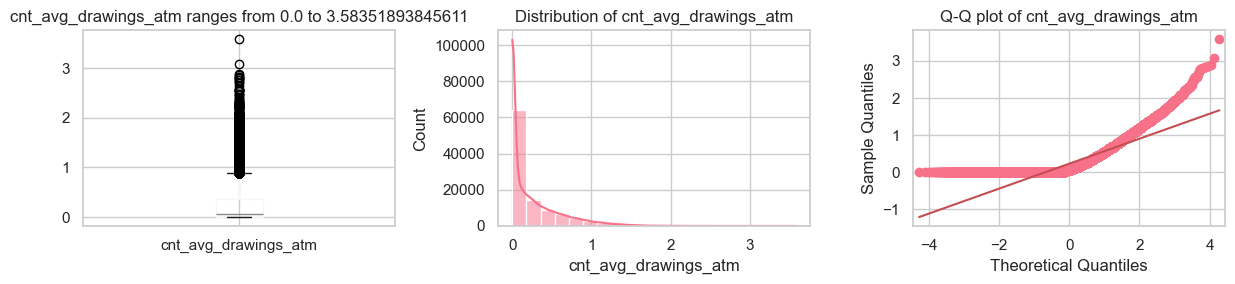

cnt_avg_drawings_pos


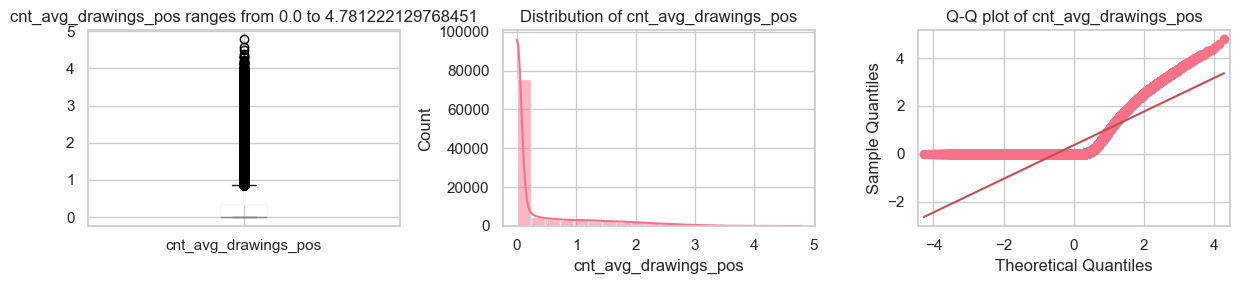

cnt_avg_drawings_other


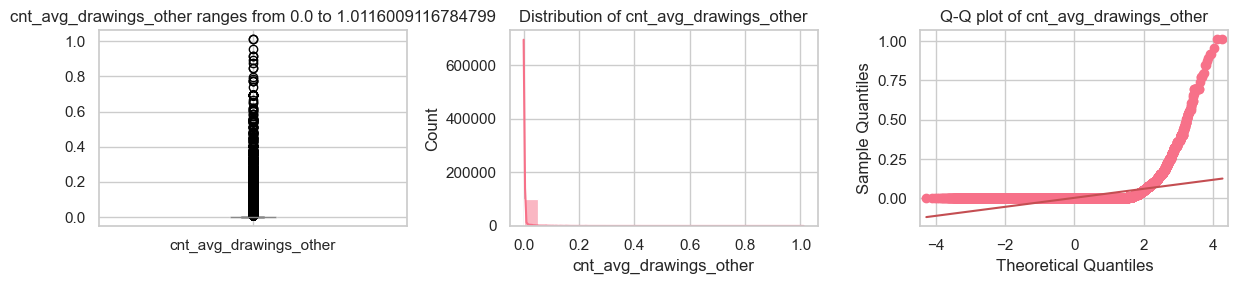

cnt_avg_drawings


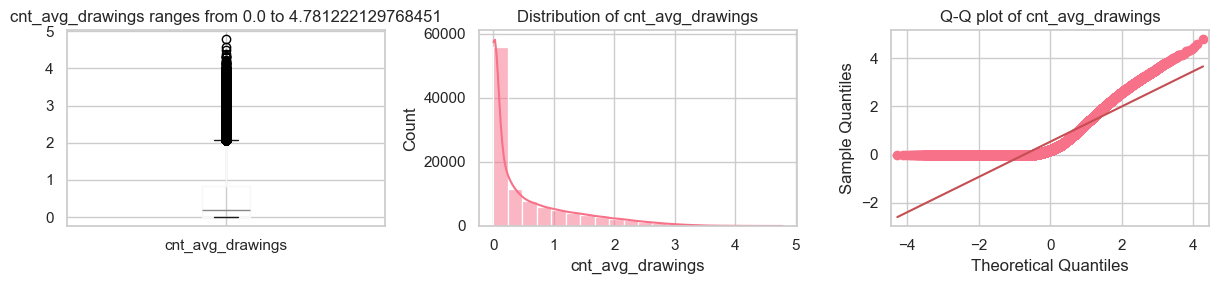

In [72]:
help_visuals.distribution_check(engineered_credit_card_balance.filter(regex='.*drawings', axis=1))

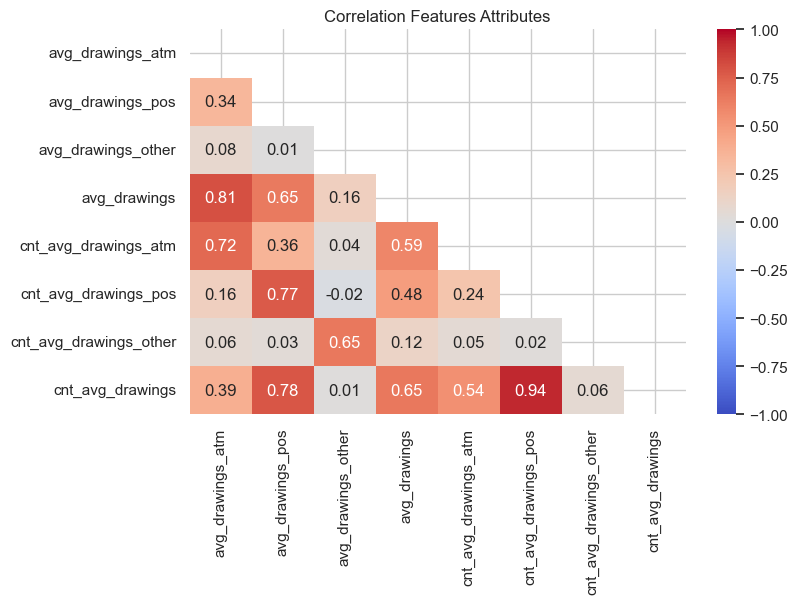

In [73]:
help_visuals.heatmap(engineered_credit_card_balance.filter(regex='.*drawings', axis=1), 'Features', 'pearson')

## Balance

In [85]:
engineered_credit_card_balance.filter(regex='.*balance', axis=1)

,avg_balance,payment_balance_ratio
0,0.000000,0.000000
1,217122.668182,0.060863
2,0.000000,0.000000
3,0.000000,0.000000
4,69687.969658,2.202702
...,...,...
104302,0.000000,0.000000
104303,0.000000,0.000000
104304,0.000000,0.000000
104305,0.000000,0.000000


avg_balance


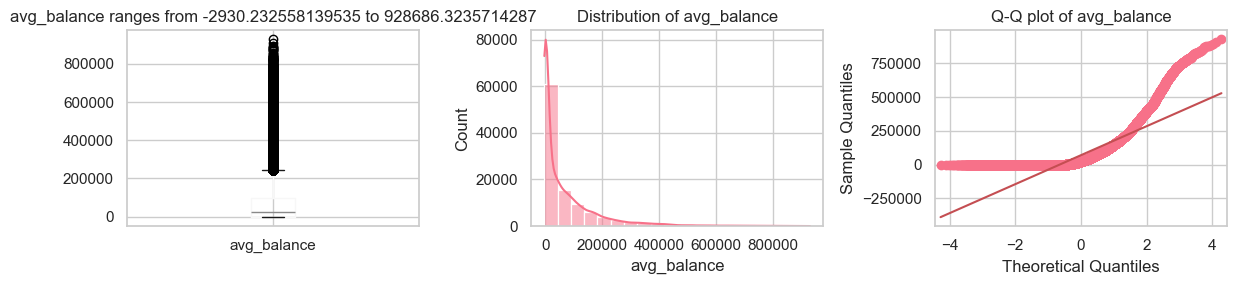

payment_balance_ratio


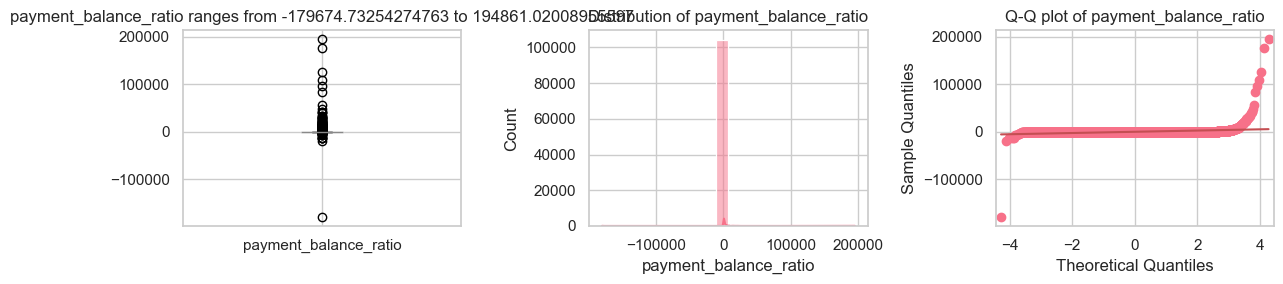

In [86]:
help_visuals.distribution_check(engineered_credit_card_balance.filter(regex='.*balance', axis=1))

Utilization Rate: AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL
Payment to Drawing Ratio: AMT_PAYMENT_TOTAL_CURRENT / AMT_DRAWINGS_CURRENT